# Create embeddings and store in Chroma using Open CLIP

## Load Libraries

In [2]:
import open_clip
import torch
from open_clip import transform

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from chromadb.utils.data_loaders import ImageLoader

import csv

import chromadb
from chromadb.utils import embedding_functions

import pandas as pd
from sklearn.model_selection import train_test_split

torch.cuda.empty_cache()


## Initialize the CLIP model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(model_name="ViT-B-32", pretrained="openai",device=device)
tokenizer = open_clip.get_tokenizer(model_name="ViT-B-32")


## Load data

In [37]:
# Reading the data

with open("apparel_products_50k.csv",'r', encoding="utf8") as file:
    lines = csv.reader(file)
    
    products = []
    metadata = []
    ids = []
    url = []
    
    for i, line in enumerate(lines):
        if i==0:
            continue
        products.append(line[1])
        metadata.append({"price": line[3],"category":line[4]})
        ids.append(line[0])
        url.append("50KImages/"+line[2])

## Instantiate the chroma db creation

In [3]:

chroma_client = chromadb.PersistentClient(path="clip_textdb")

# creating collection for text
text_collection = chroma_client.get_or_create_collection('Text_Store',metadata = {"hnsw:space": "cosine"})

# creating collection for images
image_collection = chroma_client.get_or_create_collection(name='Image_Store',metadata = {"hnsw:space": "cosine"} )

In [5]:
text_collection.count()

50000

In [75]:
image_collection.count()

50000

## Query the Result

In [96]:
query = ["Verdusa Women's Pocket Front Sleeveless Round Neck Tweed Short Bodycon Dress, black"]

# query is encoded before retrieving from the database
tokentext = tokenizer(query).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    query_features = model.encode_text(tokentext)
    query_features /= query_features.norm(dim=-1, keepdim=True)
queryemb = query_features.tolist()

result = collection.query(
    query_embeddings=queryemb,
    n_results=5,
)
result

{'ids': [['B0BYD9Y57R',
   'B0BWC787NL',
   'B0987NHT8X',
   'B0B5TWNVTH',
   'B0C6Q96ZBL']],
 'distances': [[0.6234883666038513,
   0.63597571849823,
   0.6842491030693054,
   0.722668468952179,
   0.7238789200782776]],
 'metadatas': [[{'category': '116', 'price': '44.99'},
   {'category': '116', 'price': '40.99'},
   {'category': '116', 'price': '38.99'},
   {'category': '116', 'price': '37.99'},
   {'category': '116', 'price': '29.69'}]],
 'embeddings': None,
 'documents': [["Women's Plaid Tweed Square Neck Sleeveless A Line Shift Tank Mini Dress",
   "Women's Sequin Sparkly Halter Neck Sleeveless Ruched Bodycon Party Mini Dress",
   "Women's Sexy Glitter Summer Bodycon Wrap Dress Sleeveless Cami Short Mini Club Party Dress",
   "Women's Solid Mesh Strapless Backless Tube Bodycon Party Midi Club Dress",
   "Women's Square Neck Bodice Dress Sleeveless Tank Top Stretch Flare Mini Dresses"]],
 'uris': None,
 'data': None}

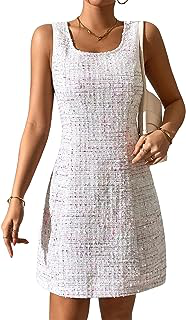

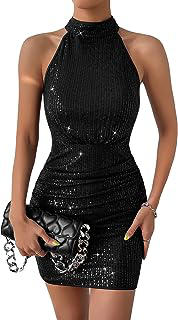

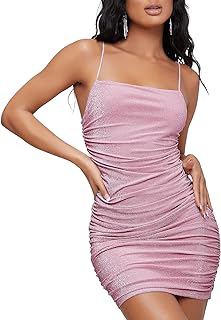

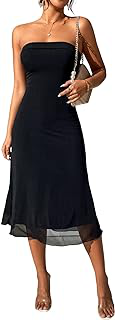

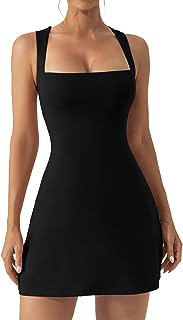

In [86]:
i = result['ids']
for j in i[0]:
    im = "50KImages/"+j+".jpg"
    img2 = Image.open(im)
    display(img2)

In [ ]:
# the query image is encoded before retrieving from the database

img = preprocess(Image.open(r"test images/verdusa women's tweed dress.jpg")).unsqueeze(0).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    query_features = model.encode_image(img)
queryemb = query_features.tolist()

results = collection2.query(
    query_embeddings=queryemb,
    #query_texts=["Skechers Men's Afterburn M. Fit"],
    n_results=5,
    include=['uris','metadatas','distances']
)

results

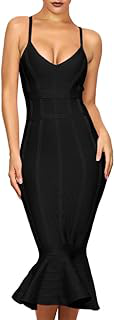

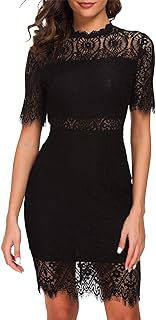

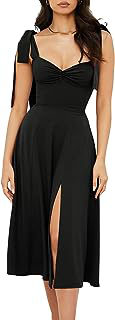

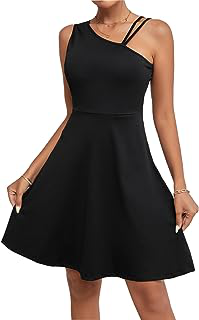

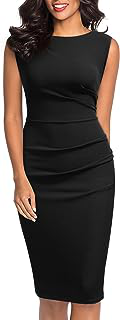

In [93]:
i = results['ids']
for j in i[0]:
    im = "50KImages/"+j+".jpg"
    img2 = Image.open(im)
    display(img2)